# COVID-19 Timelapse
### Jeremy Tuthill

The goal of this project is to visualize global trends in COVID-19 cases and deaths. I will be doing so primarily using Folium, which allows me to overlay various markers on a world map. In this case, I will use bubbles of various sizes to denote each country's share of global COVID cases and deaths at a given point in time. My ultimate goal is to export one such plot for each day since 1/22/2020 (which is when the data begins) and to combine them together into a video which displays them sequentially, thus producing a neat visualization of how the case/death distributions have changed over time.

In [2]:
#####################
##### LIBRARIES #####
#####################

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium as fl

In [3]:
############################################
##### FUNCTIONS AND CONSTANT VARIABLES #####
############################################

REGIONS = ['Grand Princess', 'Faroe Islands', 'Greenland', 'French Guiana', 'French Polynesia', 'Guadeloupe',
          'Mayotte', 'New Caledonia', 'Reunion', 'Saint Barthelemy', 'St Martin', 'Martinique', 'Aruba',
          'Curacao', 'Sint Maarten', 'Bermuda', 'Cayman Islands', 'Channel Islands', 'Gibraltar', 'Isle of Man',
          'Montserrat', 'Diamond Princess', 'Anguilla', 'British Virgin Islands', 'Turks and Caicos Islands', 
          'Bonaire, Sint Eustatius and Saba', 'Falkland Islands (Malvinas)', 'Saint Pierre and Miquelon']

# prints a dataframe in its entirety (for debugging)
def display_full_dataframe(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)
    
# redefines a given set of provinces/states as countries/regions so they can be rendered separately on a map
def separate_regions(df, regions):
    for item in regions:
        df.loc[df['Province/State'] == item, 'Country/Region'] = item

# generates a dict of aggregate functions to be used during a "groupby"
def aggregate_functions(df):
    agg_funcs = dict.fromkeys(df, 'sum')
    agg_funcs['Lat'] = 'mean'
    agg_funcs['Long'] = 'mean'
    del agg_funcs['Province/State']
    del agg_funcs['Country/Region']
    return agg_funcs

# adds a new row to a dataframe that keeps track of global totals
def add_totals(df):
    new_df = df.append(df.sum(numeric_only=True), ignore_index=True)
    new_df.iloc[-1, 0] = 'Total'
    new_df.iloc[-1, 1] = 0.0
    new_df.iloc[-1, 2] = 0.0
    return new_df

# generates a line graph of a dataframe's COVID data
def generate_plot(df, title, xlabel, ylabel):
    df.iloc[-1, 4:].plot(kind='line')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# determines the size of a circle on the world map, which is logarithmically
# proportional to a country's number of cases/deaths as a percentage of the
# global number of cases/deaths
def circle_size(cases, total_cases):
    cases_share = cases / total_cases if total_cases != 0 else 0
    return math.log(1.01 + cases_share) * 4000000.0

In [4]:
###########################
##### DATA PROCESSING #####
###########################

# import cases/deaths data from CSV files in the current directory
cases_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')

# define some provinces/states as their own countries/regions - this is important because
# many autonomous territories are rather far from the countries that preside over them
separate_regions(cases_df, REGIONS)
separate_regions(deaths_df, REGIONS)

# aggregate cases/deaths by country/region - this is necessary because some countries are
# broken up into many regions in the data set (such as Australia, Canada, and China)
cases_df = cases_df.groupby(cases_df['Country/Region']).aggregate(aggregate_functions(cases_df)).reset_index()
deaths_df = deaths_df.groupby(deaths_df['Country/Region']).aggregate(aggregate_functions(deaths_df)).reset_index()

# calculate the total cumulative number of cases/deaths on each date
cases_df = add_totals(cases_df)
deaths_df = add_totals(deaths_df)

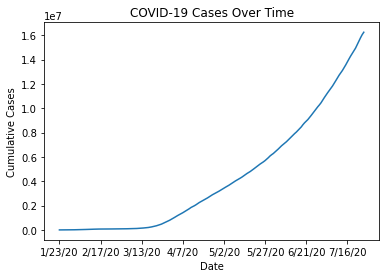

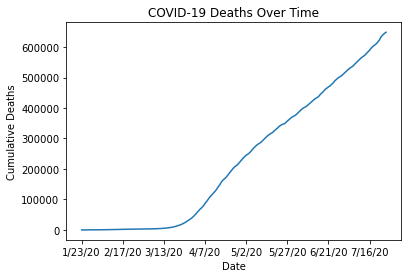

In [5]:
############################################
##### DATA VISUALIZATION - LINE GRAPHS #####
############################################

# plot cumulative global cases over time
generate_plot(cases_df, "COVID-19 Cases Over Time", "Date", "Cumulative Cases")

# plot cumulative gloval deaths over time
generate_plot(deaths_df, "COVID-19 Deaths Over Time", "Date", "Cumulative Deaths")

In [6]:
m = fl.Map(location=[32,10], zoom_start=2)

for i, row in cases_df.iterrows():
    if row['Country/Region'] != 'Total' and cases_df.iloc[i, -1] > 0.0:
        circle = fl.Circle(
            location = [row['Lat'], row['Long']],
            popup = row['Country/Region'],
            radius = circle_size(cases_df.iloc[i, -1], cases_df.iloc[-1, -1]),
            color = 'crimson',
            fill = True,
            fill_color = 'crimson'
        )
    
    circle.add_to(m)

m